In [204]:
import pandas as pd
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# Load and clean the data

In [205]:
orig_df = pd.read_csv("datasets/monthly_in_situ_co2_mlo.csv")
orig_df.columns = orig_df.columns.str.strip()
orig_df.drop([0, 1], inplace=True)
orig_df = orig_df.loc[:,~orig_df.columns.duplicated()]
orig_df.drop('Date', axis=1, inplace=True)
orig_df['Date'] = pd.to_datetime(orig_df[['Yr', 'Mn']].rename(columns={'Yr': 'year', 'Mn': 'month'}).assign(day=1))
orig_df.set_index('Date', inplace=True)
orig_df.head()

,Yr,Mn,CO2,seasonally,fit,Sta
Date,,,,,,
1958-01-01,1958,01,-99.99,-99.99,-99.99,MLO
1958-02-01,1958,02,-99.99,-99.99,-99.99,MLO
1958-03-01,1958,03,315.71,314.44,316.20,MLO
1958-04-01,1958,04,317.45,315.16,317.30,MLO
1958-05-01,1958,05,317.51,314.69,317.89,MLO


# Further clean and plot the data

<Axes: xlabel='Date'>

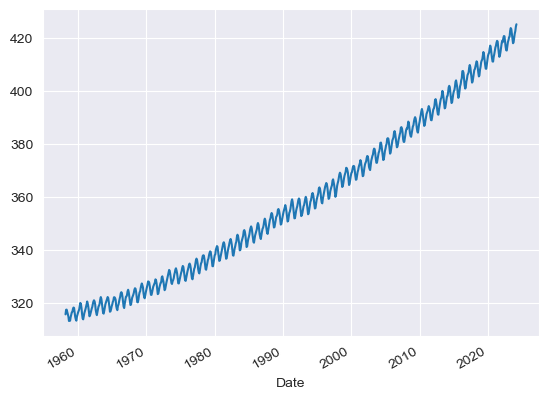

In [206]:
df = orig_df['CO2']
df = pd.to_numeric(df, errors='coerce')
df = df.loc[df != -99.99]
df.plot()

# Create lagged features

In [207]:
df = df.to_frame()

In [208]:
def create_lagged_features(series: pd.Series, lag_count: int):
    lagged_df = df.copy()
    lagged_df['CO2'] = series
    for i in range(1, lag_count + 1):
        lagged_df[f"lag_{i}"] = series.shift(i)
    return lagged_df

lag_count = 12
lagged_df = create_lagged_features(series, lag_count)
lagged_df.dropna(inplace=True)
lagged_df.head()

,CO2,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
Date,,,,,,,,,,,,,
1959-05-01,318.29,317.72,316.65,316.49,315.58,314.67,313.33,313.21,314.93,315.87,317.51,317.45,315.71
1959-06-01,318.15,318.29,317.72,316.65,316.49,315.58,314.67,313.33,313.21,314.93,315.87,317.51,317.45
1959-07-01,316.54,318.15,318.29,317.72,316.65,316.49,315.58,314.67,313.33,313.21,314.93,315.87,317.51
1959-08-01,314.80,316.54,318.15,318.29,317.72,316.65,316.49,315.58,314.67,313.33,313.21,314.93,315.87
1959-09-01,313.84,314.80,316.54,318.15,318.29,317.72,316.65,316.49,315.58,314.67,313.33,313.21,314.93


# Prepare the training and test dataset

In [209]:
X = lagged_df.drop('CO2', axis=1)
y = lagged_df['CO2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Find the optimum parameters for the RFR using Grid Search and evaluate the model

In [210]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters: {'max_depth': 20, 'max_features': None, 'n_estimators': 300}
Best score: -0.0016295920371175148


In [211]:
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)*100

0.14110455700190733

# Plot the actual vs predicted values

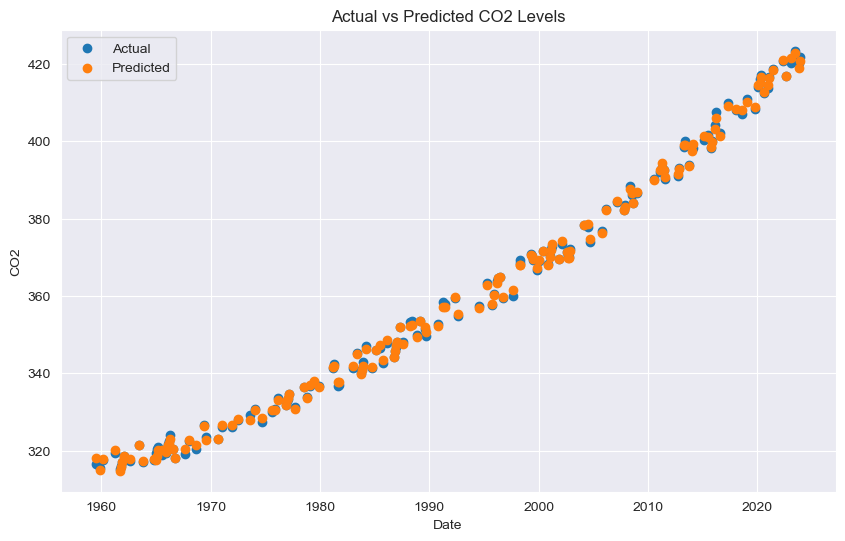

In [212]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

# Evaluate the predictions of the last 12 months of the data

In [213]:
def get_first_eval_batch(data, n):
    return data[-n:].reshape(-1, n)

def make_predictions(train_data, test_data, model, lag_count):
    test_prediction_rfr = []
    current_batch = get_first_eval_batch(train_data, lag_count)

    for _ in range(len(test_data)):
        current_batch_df = pd.DataFrame(current_batch, columns=X_train.columns)
        current_pred = model.predict(current_batch_df)[0]
        test_prediction_rfr.append(current_pred)
        current_batch = np.append(current_batch[:,1:], [[current_pred]], axis=1)

    return test_prediction_rfr

train = df[:-12]
test = df[-12:]

test_prediction_rfr = make_predictions(train["CO2"].values, test, model, lag_count)

print(test_prediction_rfr)

[422.8200666666658, 422.93786666666597, 422.91303333333286, 423.0742666666666, 422.9680666666666, 422.9014999999999, 422.8735666666663, 423.20469999999983, 423.2464333333332, 423.3911666666666, 423.5333, 423.7205000000002]


<Axes: xlabel='Date'>

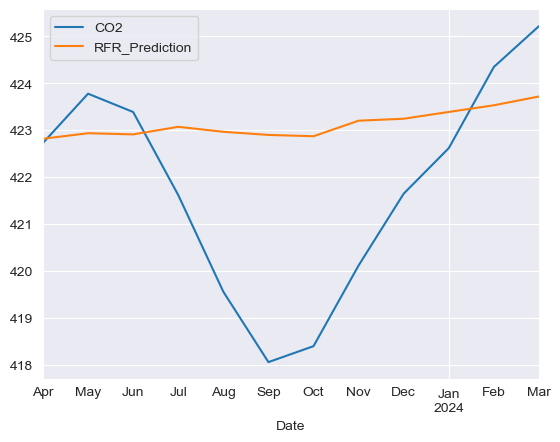

In [214]:
df_comp = test["CO2"].to_frame()
df_comp["RFR_Prediction"] = test_prediction_rfr
df_comp.plot()

The model isn't great at accounting for seasonality within the data. 

# Find optimal params for Gradient Boosting Regressor

In [218]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5, 10]
}

grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
gb_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score: -0.0016702391392238683


# Evaluate the model's performance

In [219]:
y_pred = gb_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)*100
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Absolute Percentage Error: 0.15435125610151493%


# Plot the actual vs predicted values

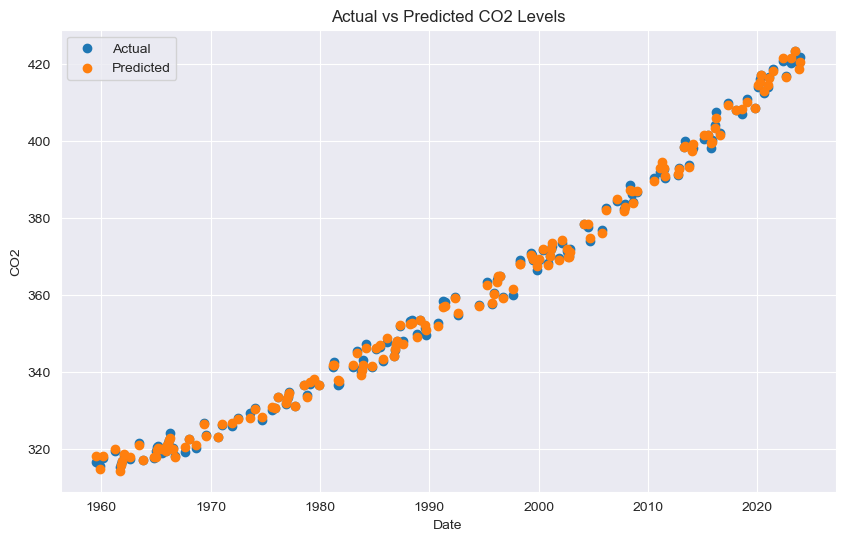

In [220]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

# Evaluate the predictions of the last 12 months of the data

<Axes: xlabel='Date'>

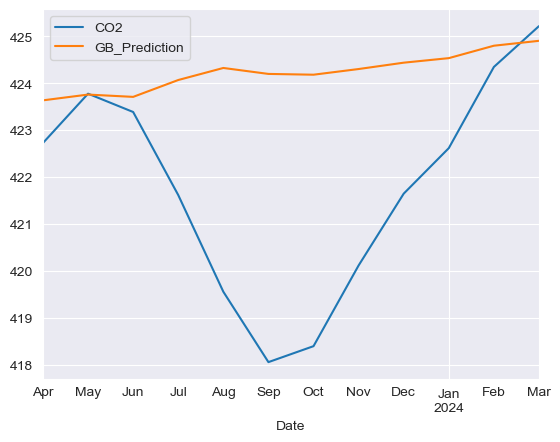

In [221]:
test_prediction_gb = make_predictions(train["CO2"].values, test, gb_model, lag_count)

df_comp = test["CO2"].to_frame()
df_comp["GB_Prediction"] = test_prediction_gb
df_comp.plot()

The Gradient Boosting Regressor model also doesn't account for the seasonality in the data.

# Find optimal params for XGBoost Regressor

In [222]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [1, 3, 5, 10]
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
xgb_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score: -0.0017647051532135478


# Evaluate the model's performance

In [223]:
y_pred = xgb_model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)*100
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Absolute Percentage Error: 0.15537982184209823%


# Plot the actual vs predicted values

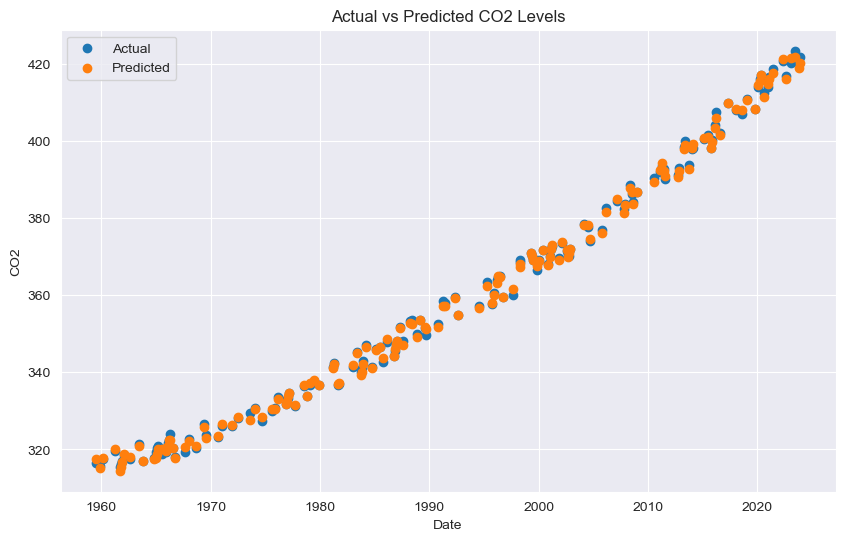

In [224]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test.index, y_test.values, label='Actual')
plt.scatter(y_test.index, y_pred, label='Predicted')
plt.xlabel('Date')
plt.ylabel('CO2')
plt.title('Actual vs Predicted CO2 Levels')
plt.legend()
plt.show()

# Evaluate the predictions of the last 12 months of the data

<Axes: xlabel='Date'>

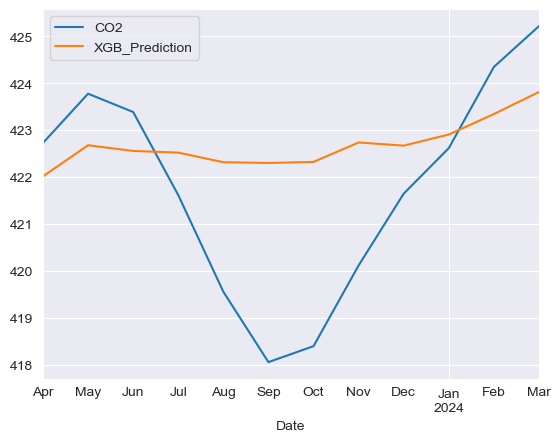

In [225]:
test_prediction_xgb = make_predictions(train["CO2"].values, test, xgb_model, lag_count)

df_comp = test["CO2"].to_frame()
df_comp["XGB_Prediction"] = test_prediction_xgb
df_comp.plot()

# Conclusion
The Random Forest Regressor model was the best performing model with a Mean Absolute Percentage Error of 0.14%. However, the model doesn't account for the seasonality in the data. The Gradient Boosting Regressor and XGBoost Regressor models also don't account for the seasonality in the data. A solution to this problem could be feeding the month as a separate feature to the model. Another solution could be to use a time series model like ARIMA or Prophet.